<a href="https://colab.research.google.com/github/Nachi2006/MLREPO/blob/main/Childemotiondetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import files

# 1. Upload the kaggle.json file you just downloaded
print("Please upload your kaggle.json file:")
files.upload()

# 2. Move it to the correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API configured successfully!")

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Kaggle API configured successfully!


In [3]:
# Install Kaggle API if not already installed
!pip install kaggle

# Download the datasets
!kaggle datasets download -d programmer3/multimodal-child-emotion-for-learning
!kaggle datasets download -d jangedoo/utkface-new
!kaggle datasets download -d mulukentesfaye/fgnet  # If this link is broken, use aiolapo/fgnet-dataset

# Unzip them
!unzip -q multimodal-child-emotion-for-learning.zip -d multimodal_dataset
!unzip -q utkface-new.zip -d utkface_dataset
!unzip -q fgnet.zip -d fgnet_dataset

Dataset URL: https://www.kaggle.com/datasets/programmer3/multimodal-child-emotion-for-learning
License(s): CC0-1.0
 97% 671M/689M [00:04<00:00, 199MB/s]
100% 689M/689M [00:04<00:00, 172MB/s]
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 81% 268M/331M [00:00<00:00, 648MB/s] 
100% 331M/331M [00:00<00:00, 641MB/s]
Dataset URL: https://www.kaggle.com/datasets/mulukentesfaye/fgnet
License(s): unknown
  0% 0.00/44.1M [00:00<?, ?B/s]
100% 44.1M/44.1M [00:00<00:00, 1.34GB/s]


In [4]:
import os
import shutil
import pandas as pd

# Define paths (adjust these to match your unzipped folder structure)
utk_path = './utkface_dataset/UTKFace'  # Check if it's 'UTKFace' or 'crop_part1'
fgnet_path = './fgnet_dataset/FGNET/images' # Adjust based on actual unzip path
multimodal_path = './multimodal_dataset'

# Output directory
output_dir = './Final_Children_Dataset_2_5'
os.makedirs(output_dir, exist_ok=True)

# --- 1. Filter UTKFace ---
print("Filtering UTKFace...")
for filename in os.listdir(utk_path):
    if not filename.endswith('.jpg'): continue

    # Parse filename: 2_0_0_20170110225557604.jpg.chip.jpg
    parts = filename.split('_')
    try:
        age = int(parts[0])
        if 2 <= age <= 5:
            # We don't have attentive labels, so we save them to a generic folder or 'Unlabeled'
            # You will need to manually sort these later!
            shutil.copy(os.path.join(utk_path, filename), os.path.join(output_dir, f"UTK_{filename}"))
    except ValueError:
        continue

# --- 2. Filter FG-NET ---
print("Filtering FG-NET...")
for filename in os.listdir(fgnet_path):
    # Format example: 001A02.JPG (Subject 1, Age 2)
    # We look for 'A' followed by digits
    upper_name = filename.upper()
    if 'A' in upper_name and (upper_name.endswith('.JPG') or upper_name.endswith('.PNG')):
        try:
            # Extract part after 'A' and before '.'
            age_part = upper_name.split('A')[-1].split('.')[0]
            # Sometimes there are extra suffixes, take first 2 chars just in case
            age = int(''.join(filter(str.isdigit, age_part)))

            if 2 <= age <= 5:
                shutil.copy(os.path.join(fgnet_path, filename), os.path.join(output_dir, f"FGNET_{filename}"))
        except ValueError:
            continue



Filtering UTKFace...
Filtering FG-NET...


In [6]:
import os

# Path to your final dataset
dataset_path = './Final_Children_Dataset_2_5'

total_count = 0
utk_count = 0
fgnet_count = 0
multimodal_count = 0

print(f"Scanning {dataset_path}...\n")

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        # Check for image extensions
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            total_count += 1

            # Check prefix to see source (based on previous script)
            if file.startswith("UTK_"):
                utk_count += 1
            elif file.startswith("FGNET_"):
                fgnet_count += 1
            else:
                # Assume anything else is from the Multimodal dataset
                multimodal_count += 1

print("--- Dataset Statistics ---")
print(f"UTKFace images (2-5 yrs):   {utk_count}")
print(f"FG-NET images (2-5 yrs):    {fgnet_count}")
print("-" * 30)
print(f"TOTAL DATASET SIZE:         {total_count} images")

Scanning ./Final_Children_Dataset_2_5...

--- Dataset Statistics ---
UTKFace images (2-5 yrs):   1240
FG-NET images (2-5 yrs):    158
------------------------------
TOTAL DATASET SIZE:         1398 images


In [7]:
!pip install pigeon-jupyter

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.4 MB/s eta 0:00:00
  Created wheel for pigeon-jupyter: filename=pigeon_jupyter-0.1.0-py3-none-any.whl size=3865 sha256=2b02b1f7e45227c0679d978f9b70070012e24e6fca8a4fad2c857d41443d9940
  Stored in directory: /root/.cache/pip/wheels/2c/55/ef/43a86d66313cb16ff952e509365baf5ac3e60516ee4c4405b0
Successfully built pigeon-jupyter


In [9]:
from pigeon import annotate
import os
from IPython.display import display, Image

# 1. Get list of all image paths
dataset_path = './Final_Children_Dataset_2_5'
all_images = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            all_images.append(os.path.join(root, file))

# 2. Start Annotating
# Click 'Attentive' or 'Not_Attentive'.
# Results are saved in 'annotations' list as tuples: (filepath, label)
annotations = annotate(
    all_images,
    options=['Attentive', 'Not_Attentive'],
    display_fn=lambda filename: display(Image(filename, width=300))
)

HTML(value='0 examples annotated, 1399 examples left')

Output()

Annotation done.


In [10]:
import pandas as pd
df = pd.DataFrame(annotations, columns=['file_path', 'label'])
df.to_csv('attentiveness_labels.csv', index=False)
print("Saved annotations to csv!")

Saved annotations to csv!


In [11]:
import pandas as pd
import numpy as np
import os
import tensorflow as tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 1. Load the labels
df = pd.read_csv('attentiveness_labels.csv')

# Check distribution (It's good to have roughly equal numbers)
print("Label Distribution:")
print(df['label'].value_counts())

# 2. Split into Train and Validation sets
# We use stratify to ensure both train and val have a mix of Attentive/Not_Attentive
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(f"Training images: {len(train_df)}")
print(f"Validation images: {len(val_df)}")

Label Distribution:
label
Attentive        986
Not_Attentive    412
Name: count, dtype: int64
Training images: 1118
Validation images: 280


Total samples: 1398
label
Attentive        986
Not_Attentive    412
Name: count, dtype: int64
Training samples: 1118
Validation samples: 280


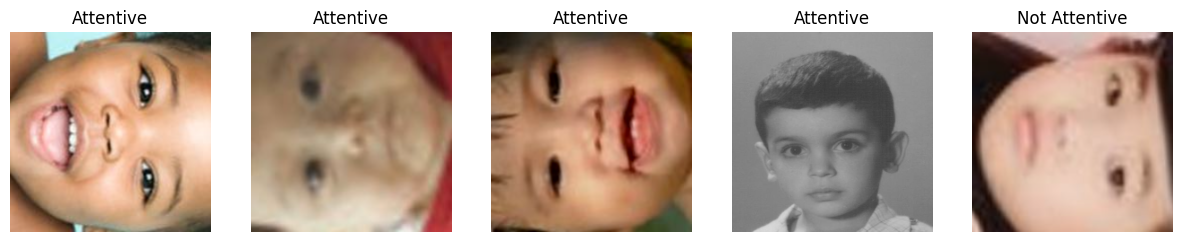

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import os

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load your annotations
df = pd.read_csv('attentiveness_labels.csv')
print(f"Total samples: {len(df)}")
print(df['label'].value_counts())

# Create a dictionary for label encoding
label_dict = {'Attentive': 1, 'Not_Attentive': 0}

# Split data
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

# Save splits for reference
train_df.to_csv('train_split.csv', index=False)
val_df.to_csv('val_split.csv', index=False)

# Create TensorFlow data pipeline
IMG_SIZE = (224, 224)  # Standard size for most pretrained models
BATCH_SIZE = 32

def load_and_preprocess_image(path, label):
    """Load and preprocess a single image"""
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
    return image, label

def create_dataset(df, training=False):
    """Create TensorFlow dataset from DataFrame"""
    # Convert labels to integers
    labels = df['label'].map(label_dict).values
    paths = df['file_path'].values

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))

    # Load and preprocess images
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

    if training:
        # Apply data augmentation only during training
        dataset = dataset.map(
            lambda x, y: (augment_image(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Define data augmentation
def augment_image(image):
    """Apply augmentations to training images"""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    # Add slight rotation
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image

# Create datasets
train_dataset = create_dataset(train_df, training=True)
val_dataset = create_dataset(val_df, training=False)

# Visualize some samples
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 5))
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, BATCH_SIZE)):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i].numpy())
            plt.title("Attentive" if labels[i].numpy() == 1 else "Not Attentive")
            plt.axis('off')
    plt.show()

visualize_samples(train_dataset)

In [16]:
def create_transfer_model(model_name='EfficientNetB0'):
    """Create model using transfer learning"""
    # Base model (pretrained on ImageNet, without top layers)
    if model_name == 'EfficientNetB0':
        base_model = keras.applications.EfficientNetB0(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
    elif model_name == 'ResNet50':
        base_model = keras.applications.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )
    elif model_name == 'MobileNetV2':
        base_model = keras.applications.MobileNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(224, 224, 3)
        )

    # Freeze base model initially
    base_model.trainable = False

    # Add custom layers on top
    inputs = keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs)

    return model, base_model

# Create transfer learning model
model, base_model = create_transfer_model('EfficientNetB0')
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall')]
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,788 (16.70 MB)

 Trainable params: 328,705 (1.25 MB)

 Non-trainable params: 4,050,083 (15.45 MB)

In [17]:
import datetime

# Create callbacks
checkpoint_path = "best_model.keras"

callbacks = [
    # Early stopping
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Model checkpoint
    keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Reduce learning rate on plateau
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # TensorBoard logging
    keras.callbacks.TensorBoard(
        log_dir=f"logs/fit/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}",
        histogram_freq=1
    )
]

# Train the model
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train')
    axes[0, 1].plot(history.history['val_loss'], label='Validation')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train')
    axes[1, 0].plot(history.history['val_precision'], label='Validation')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train')
    axes[1, 1].plot(history.history['val_recall'], label='Validation')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5546 - loss: 0.8311 - precision: 0.7172 - recall: 0.5966
Epoch 1: val_accuracy improved from -inf to 0.70357, saving model to best_model.keras
35/35 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.5551 - loss: 0.8299 - precision: 0.7170 - recall: 0.5984 - val_accuracy: 0.7036 - val_loss: 0.6461 - val_precision: 0.7036 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6802 - loss: 0.6697 - precision: 0.7217 - recall: 0.8946
Epoch 2: val_accuracy did not improve from 0.70357
35/35 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step - accuracy: 0.6799 - loss: 0.6701 - precision: 0.7215 - recall: 0.8945 - val_accuracy: 0.7036 - val_loss: 0.6125 - val_precision: 0.7036 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6480 - loss: 0.6827 - precision: 0.6973 - recall: 0.8801
Epoch 3: val_accuracy did not improve from 0.70357
35/35 ━━

KeyboardInterrupt: 

=== OVERALL DISTRIBUTION ===
label
Attentive        986
Not_Attentive    412
Name: count, dtype: int64
Attentive: 70.5%

=== TRAINING SET ===
label
Attentive        789
Not_Attentive    329
Name: count, dtype: int64
Attentive: 70.6%

=== VALIDATION SET ===
label
Attentive        197
Not_Attentive     83
Name: count, dtype: int64
Attentive: 70.4%

=== MODEL DIAGNOSTIC ===
⚠️  WARNING: High class imbalance (>65% Attentive)
   Model may be learning to always predict 'Attentive'

=== SAMPLE IMAGES ===


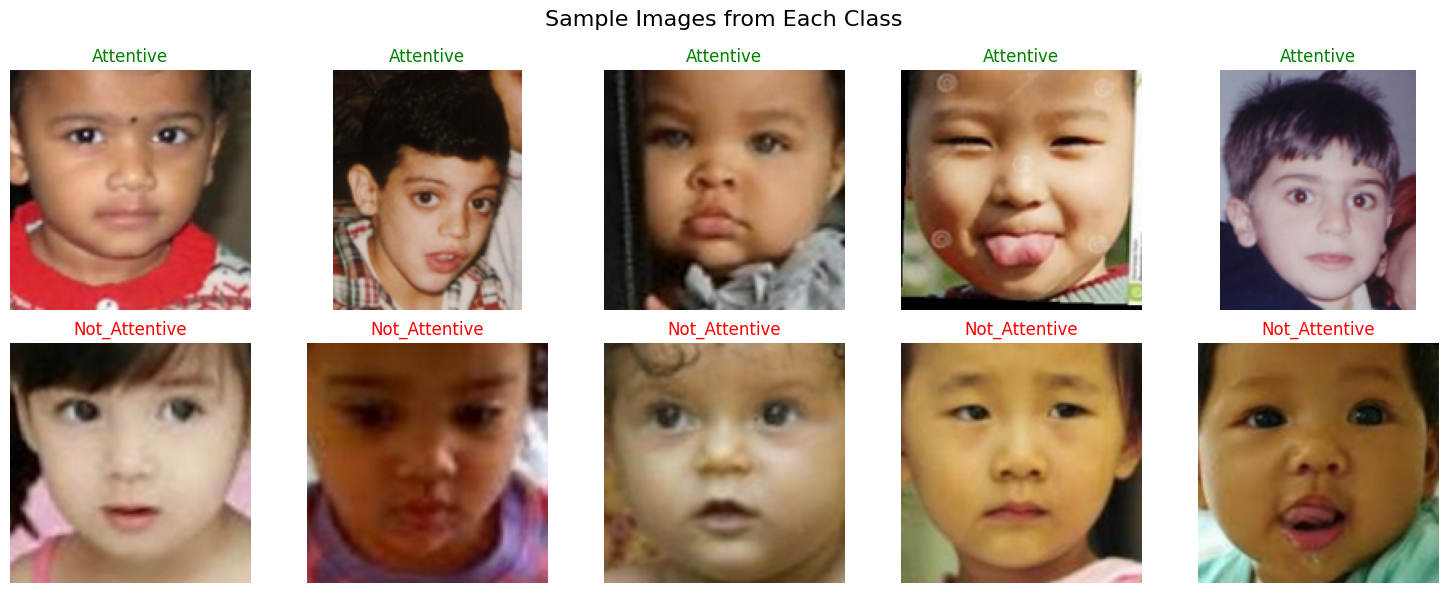

In [18]:
import pandas as pd
import numpy as np

# Load your data
df = pd.read_csv('attentiveness_labels.csv')

# 1. Check overall distribution
print("=== OVERALL DISTRIBUTION ===")
print(df['label'].value_counts())
print(f"Attentive: {len(df[df['label']=='Attentive'])/len(df):.1%}")

# 2. Check if stratified split worked
train_df = pd.read_csv('train_split.csv')
val_df = pd.read_csv('val_split.csv')

print("\n=== TRAINING SET ===")
print(train_df['label'].value_counts())
print(f"Attentive: {len(train_df[train_df['label']=='Attentive'])/len(train_df):.1%}")

print("\n=== VALIDATION SET ===")
print(val_df['label'].value_counts())
print(f"Attentive: {len(val_df[val_df['label']=='Attentive'])/len(val_df):.1%}")

# 3. Quick model diagnostic
print("\n=== MODEL DIAGNOSTIC ===")
if len(val_df[val_df['label']=='Attentive'])/len(val_df) > 0.65:
    print("⚠️  WARNING: High class imbalance (>65% Attentive)")
    print("   Model may be learning to always predict 'Attentive'")

# 4. Sample check
print("\n=== SAMPLE IMAGES ===")
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, (label, group) in enumerate(df.groupby('label')):
    samples = group.sample(5, random_state=42)
    for i, (_, row) in enumerate(samples.iterrows()):
        ax = axes[idx, i]
        img = Image.open(row['file_path'])
        img.thumbnail((150, 150))
        ax.imshow(img)
        ax.set_title(f"{label}", color='green' if label=='Attentive' else 'red')
        ax.axis('off')
plt.suptitle('Sample Images from Each Class', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# --- 1. Configuration ---
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

# --- 2. Load Data ---
if not os.path.exists('attentiveness_labels.csv'):
    raise FileNotFoundError("attentiveness_labels.csv not found.")

df = pd.read_csv('attentiveness_labels.csv')
label_map = {'Attentive': 1, 'Not_Attentive': 0}
df['target'] = df['label'].map(label_map)

# Stratified Split
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['target'], random_state=SEED
)

print(f"Training: {len(train_df)}")
print(f"Validation: {len(val_df)}")

# --- 3. Robust Data Pipeline (MobileNetV2 Style) ---

def load_and_preprocess(path, label):
    """
    Loads image and applies MobileNetV2 specific preprocessing.
    MobileNetV2 expects values between -1 and 1.
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)

    # Cast to float, but DO NOT divide by 255 manually.
    # Let the keras utility handle the specific scaling [-1, 1]
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)

    return image, label

def augment(image, label):
    """
    Applies random transformations to increase data variety.
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    # Random Zoom (Resize + Crop)
    image = tf.image.resize(image, [240, 240])
    image = tf.image.random_crop(image, size=[IMG_SIZE[0], IMG_SIZE[1], 3])
    return image, label

# Train Dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_df['file_path'].values, train_df['target'].values))
train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_df['file_path'].values, val_df['target'].values))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- 4. Build Model (MobileNetV2) ---

def build_mobilenet_model():
    # MobileNetV2 is lighter and often converges faster on small data
    base_model = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )

    base_model.trainable = False # Start frozen

    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)

    x = layers.GlobalAveragePooling2D()(x)

    # Simple, robust head
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    return keras.Model(inputs, outputs)

model = build_mobilenet_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(name='precision'), keras.metrics.Recall(name='recall')]
)

model.summary()

# --- 5. Training ---

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_mobilenet.keras", save_best_only=True, monitor='val_loss', mode='min'
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=8, restore_best_weights=True, monitor='val_loss'
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6
)

print("\nStarting Training (MobileNetV2)...")

# We REMOVE class_weight for now to let the model stabilize naturally.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb]
)

# --- 6. Plotting ---
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Train Acc')
    plt.plot(epochs, val_acc, label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

plot_results(history)

Training: 1118
Validation: 280


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345,153 (8.95 MB)

 Trainable params: 84,609 (330.50 KB)

 Non-trainable params: 2,260,544 (8.62 MB)


Starting Training (MobileNetV2)...
Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.5292 - loss: 0.9479 - precision: 0.7451 - recall: 0.5178 - val_accuracy: 0.6679 - val_loss: 0.6461 - val_precision: 0.7131 - val_recall: 0.8832 - learning_rate: 0.0010
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.7044 - loss: 0.6544 - precision: 0.7611 - recall: 0.8389 - val_accuracy: 0.7071 - val_loss: 0.6355 - val_precision: 0.7186 - val_recall: 0.9594 - learning_rate: 0.0010
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7715 - loss: 0.4785 - precision: 0.8094 - recall: 0.8927 - val_accuracy: 0.7107 - val_loss: 0.6060 - val_precision: 0.7231 - val_recall: 0.9543 - learning_rate: 0.0010
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7805 - loss: 0.4626 - precision: 0.8159 - recall: 0.8889 - val_accuracy: 0.6964 - val_loss: 0.6233 - val_precision: 0.7276 - val_recall: 0.9086 - learning_rate: 0.0010
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━